# Lista 4

Alunos:
Eduardo Brasil Araujo
Renalvo Alves Ferreira Júnior

# Questão 1

# Questão 2

# Questão 3

In [60]:
import cv2
import os
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn import svm
import numpy as np

In [43]:
# dataset = datasets.load_files('./datasets/q4-dataset/DogsCats')
class SampleData:
    def __init__(self):
        self.data = []
        self.target = []
    
    def convert(self):
        self.data = np.array(self.data)
        self.target = np.array(self.target)

dataset = SampleData()

def get_images(input_dict, image_path, label):
    for file in os.listdir(image_path):
        input_dict.data.append(np.array(cv2.imread(os.path.join(image_path, file))))
        input_dict.target.append(label)

get_images(dataset, './datasets/q4-dataset/DogsCats/Cats/', 0)
get_images(dataset, './datasets/q4-dataset/DogsCats/Dogs/', 1)

dataset.convert()

In [44]:
X = np.array(dataset.data)
y = np.array(dataset.target)

X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

In [67]:
X_train.shape

(75, 256, 256, 3)

## Letter A

In [46]:
X_hog_train, X_hog_test = X_train.copy(), X_test.copy()

In [47]:
hog = cv2.HOGDescriptor()

def convert_hog(input_list):
    global hog
    ret_list = []
    for image in input_list:
        ret_list.append(hog.compute(image))
    return ret_list
        
X_hog_train = convert_hog(X_hog_train)
X_hog_test = convert_hog(X_hog_test)

In [50]:
classifier = svm.SVC()
classifier.fit(X_hog_train, y_train)

SVC()

In [52]:
result = classifier.predict(X_hog_test)

In [63]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [61]:
accuracy = accuracy_score(y_test, result)
cmatrix = confusion_matrix(y_test, result)

Acurácia de 100.0 %


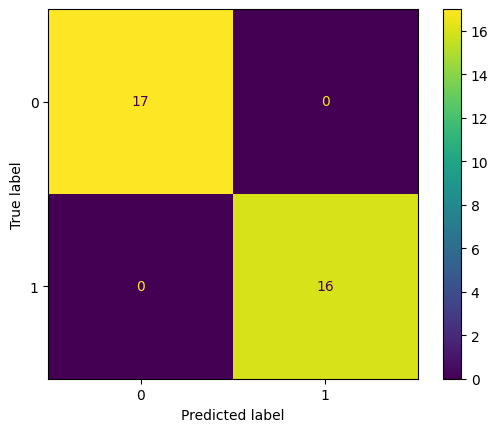

In [64]:
print(f'Acurácia de {accuracy * 100} %')
disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0,1])
disp.plot()
plt.show()

## Letter B

In [89]:
import tensorflow as tf
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras.layers import Dense, Flatten

In [66]:
input_shape = (244, 244, 3)

In [78]:
vgg16_input_train = X_train.copy()
vgg16_input_test = X_test.copy()

def to_convert_vgg16(input_list, out_shape):
    ret_list = []
    for image in input_list:
        ret = cv2.resize(image, dsize=out_shape[:2])
        ret_list.append(ret)
    return np.array(ret_list)

vgg16_input_train = to_convert_vgg16(vgg16_input_train, input_shape)
vgg16_input_test = to_convert_vgg16(vgg16_input_test, input_shape)

In [70]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

58889256/58889256 [==============================] - 6s 0us/step


In [71]:
for layer in vgg16.layers:
    layer.trainable = False

In [86]:
vgg16_model = tf.keras.models.Sequential([
    vgg16,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [87]:
vgg16_model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [88]:
vgg16_history = vgg16_model.fit(vgg16_input_train,
                    y_train,
                    epochs=3,
                    validation_data=(vgg16_input_test, y_test))

Epoch 1/3
3/3 [==============================] - 19s 7s/step - loss: 8.6705 - accuracy: 0.6267 - val_loss: 3.2336e-20 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 20s 7s/step - loss: 7.1345e-28 - accuracy: 1.0000 - val_loss: 1.4120e-29 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 20s 7s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 9.9333e-36 - val_accuracy: 1.0000


In [90]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

9406464/9406464 [==============================] - 1s 0us/step


In [92]:
for layer in resnet50.layers:
    layer.trainable = False

for layer in mobilenetv2.layers:
    layer.trainable = False

In [93]:
resnet50_model = tf.keras.models.Sequential([
    resnet50,
    Flatten(),
    Dense(1, activation='sigmoid')
])

mobilenetv2_model = tf.keras.models.Sequential([
    mobilenetv2,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [94]:
resnet50_model.compile(loss='binary_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(),
                       metrics=['accuracy'])

mobilenetv2_model.compile(loss='binary_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])

In [95]:
resnet50_history = resnet50_model.fit(vgg16_input_train,
                                      y_train,
                                      epochs=3,
                                      validation_data=(vgg16_input_test, y_test))

mobilenetv2_history = mobilenetv2_model.fit(vgg16_input_train,
                                            y_train,
                                            epochs=3,
                                            validation_data=(vgg16_input_test, y_test))

Epoch 1/3
3/3 [==============================] - 13s 4s/step - loss: 0.4894 - accuracy: 0.8133 - val_loss: 5.3276e-08 - val_accuracy: 1.0000
Epoch 2/3
3/3 [==============================] - 8s 3s/step - loss: 2.8425e-08 - accuracy: 1.0000 - val_loss: 3.1644e-12 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 8s 3s/step - loss: 5.7487e-13 - accuracy: 1.0000 - val_loss: 5.2568e-15 - val_accuracy: 1.0000
Epoch 1/3
3/3 [==============================] - 6s 1s/step - loss: 0.4604 - accuracy: 0.7467 - val_loss: 0.7564 - val_accuracy: 0.7273
Epoch 2/3
3/3 [==============================] - 2s 878ms/step - loss: 0.3179 - accuracy: 0.9067 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 3/3
3/3 [==============================] - 2s 876ms/step - loss: 2.7129e-04 - accuracy: 1.0000 - val_loss: 0.1859 - val_accuracy: 0.9697


In [102]:
def get_acc_cm(model, name):
    print(f'Resultados para o modelo {name}')
    global vgg16_input_test, y_test
    result = np.array(model.predict(vgg16_input_test))
    result[result > 0.5] = 1
    result[result <= 0.5] = 0
    
    accuracy = accuracy_score(y_test, result)
    cmatrix = confusion_matrix(y_test, result)

    print(f'Acurácia de {accuracy * 100} %')
    disp = ConfusionMatrixDisplay(confusion_matrix=cmatrix, display_labels=[0,1])
    disp.plot()
    plt.show()

Resultados para o modelo VGG16
2/2 [==============================] - 5s 171ms/step
Acurácia de 100.0 %


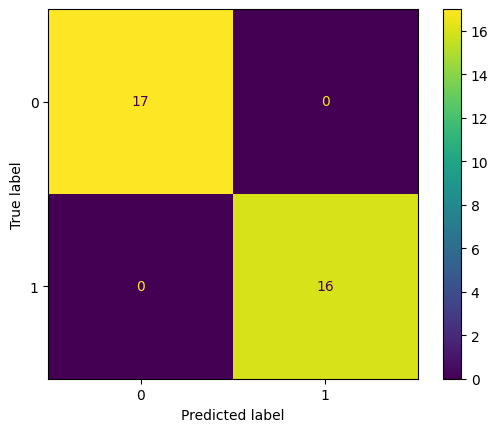

Resultados para o modelo ResNet50
2/2 [==============================] - 3s 116ms/step
Acurácia de 100.0 %


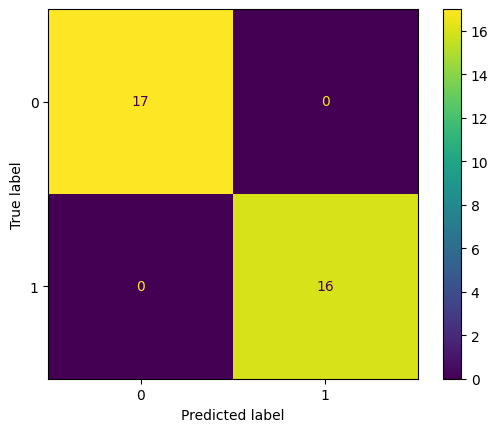

Resultados para o modelo MobileNetV2
2/2 [==============================] - 1s 32ms/step
Acurácia de 96.96969696969697 %


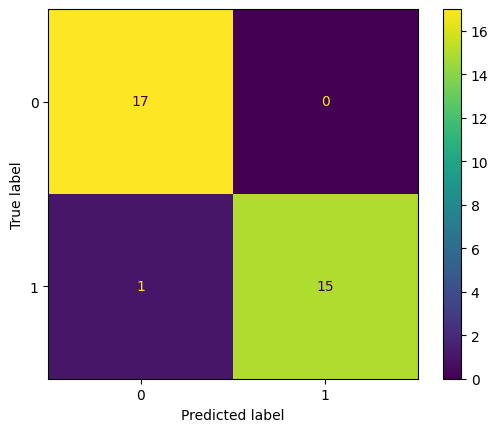

In [103]:
get_acc_cm(vgg16_model, 'VGG16')
get_acc_cm(resnet50_model, 'ResNet50')
get_acc_cm(mobilenetv2_model, 'MobileNetV2')

In [108]:
print(vgg16_input_test.shape)

(33, 244, 244, 3)


Mostrando exemplo de classificação do modelo VGG16
1/1 [==============================] - 0s 232ms/step
O resultado foi correto


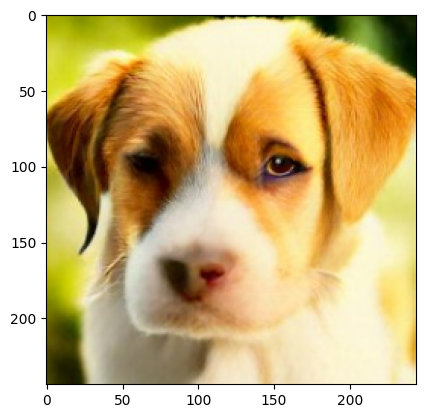

Mostrando exemplo de classificação do modelo ResNet50
1/1 [==============================] - 0s 284ms/step
O resultado foi correto


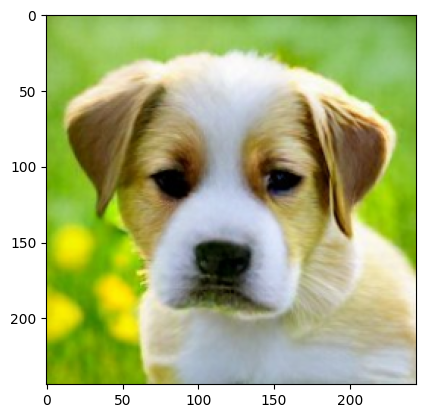

Mostrando exemplo de classificação do modelo MobileNetV2
1/1 [==============================] - 0s 55ms/step
O resultado foi incorreto


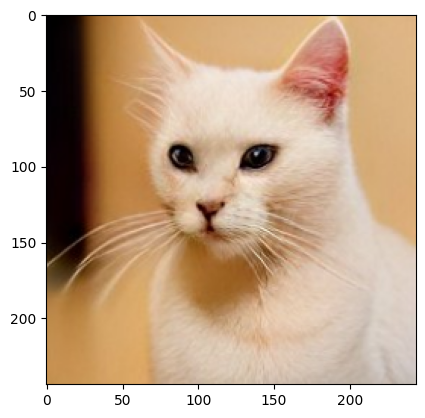

In [114]:
show_examples = []

for image, value in zip(vgg16_input_test, y_test):
    show_examples.append([image, value])

np.random.seed(42)
np.random.shuffle(show_examples)

models_list = [[vgg16_model, 'VGG16'],
               [resnet50_model, 'ResNet50'],
               [mobilenetv2_model, 'MobileNetV2']]

for (image, value), (model, name) in zip(show_examples[:3], models_list):
    print(f'Mostrando exemplo de classificação do modelo {name}')
    prediction = model.predict(np.array([image]))
    print(f'O resultado foi {"correto" if prediction == value else "incorreto"}')
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Questão 4